In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [5]:
# Load the preprocessed dataset
print("Loading dataset...")
preprocessed_dataset = pd.read_csv('/content/drive/MyDrive/dataset/preprocessed_battery_data.csv')

print(preprocessed_dataset.shape)

Loading dataset...
(8766, 8)


In [6]:
# Separate features and target
features = preprocessed_dataset.drop('SOH', axis=1)
target = preprocessed_dataset['SOH']

print(features.shape)
print(target.shape)

(8766, 7)
(8766,)


In [7]:
# Scale the data
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the features and target
X = feature_scaler.fit_transform(features)
y = target_scaler.fit_transform(target.values.reshape(-1, 1))

In [8]:
# Split the data with better ratios
train_ratio, val_ratio = 0.8, 0.1
train_size = int(len(preprocessed_dataset) * train_ratio)
val_size = int(len(preprocessed_dataset) * val_ratio)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(7012, 7)
(878, 7)
(876, 7)


In [9]:
#ARIMA model
auto_arima_model = auto_arima(
    y_train,
    exogenous=X_train,
    start_p=0, start_q=0,
    max_p=3, max_q=3, max_d=2,
    m=12,  # Add seasonal component
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic'
)
best_order = auto_arima_model.order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-24695.567, Time=19.96 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-24699.568, Time=2.36 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-24695.568, Time=9.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-24695.567, Time=6.56 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-24701.237, Time=0.36 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-24697.568, Time=5.69 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-24697.568, Time=8.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-24697.568, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-24697.567, Time=2.28 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-24695.567, Time=7.63 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 62.698 seconds


In [10]:
# Create and fit the ARIMA model
model = ARIMA(y_train, exog=X_train, order=best_order)
results = model.fit()

In [11]:
# Make predictions
predictions = results.forecast(steps=len(y_test), exog=X_test)

In [12]:
# Inverse transform predictions and actual values
predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test)

In [13]:
# Calculate multiple metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Root Mean Squared Error: 3.317800887171739
Mean Absolute Error: 3.1626433355894594
R² Score: 0.6223446085087136


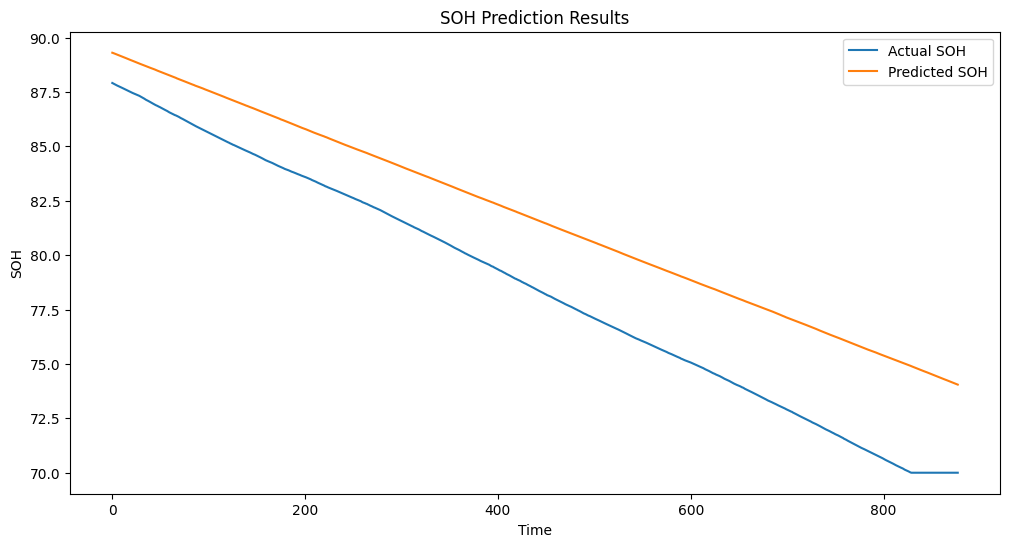

In [14]:
# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual SOH')
plt.plot(predictions, label='Predicted SOH')
plt.title('SOH Prediction Results')
plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.show()